# Loading the data

# Importing required libraries

In [ ]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib.gridspec import GridSpec
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2026-01-02 18:53:58.617140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767380039.129557      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767380039.250942      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767380040.372432      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767380040.372484      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767380040.372487      55 computation_placer.cc:177] computation placer alr

# Loading the dataset

you can download the data from https://www.kaggle.com/datasets/anshulm257/rice-disease-dataset and modify the path in the code

In [2]:
data_dir = "../input/rice-disease-dataset/Rice_Leaf_AUG"

In [3]:
data_dir = Path(data_dir)

In [4]:
images = []
labels = []

In [5]:
category_names = []
for subdir in data_dir.iterdir():
    if subdir.is_dir():
        category_names.append(subdir.name)
        for image_path in list(data_dir.glob(f"{subdir.name}/*")):
            images.append(image_path)
            labels.append(subdir.name)
print("categories", category_names)

categories ['Leaf scald', 'Sheath Blight', 'Healthy Rice Leaf', 'Leaf Blast', 'Brown Spot', 'Bacterial Leaf Blight']


In [6]:
print("total numbe of images:",len(images))

total numbe of images: 3829


In [7]:
df = pd.DataFrame({'image': images, 'label': labels})

In [8]:
df.head()

,image,label
0,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf scald
1,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf scald
2,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf scald
3,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf scald
4,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf scald


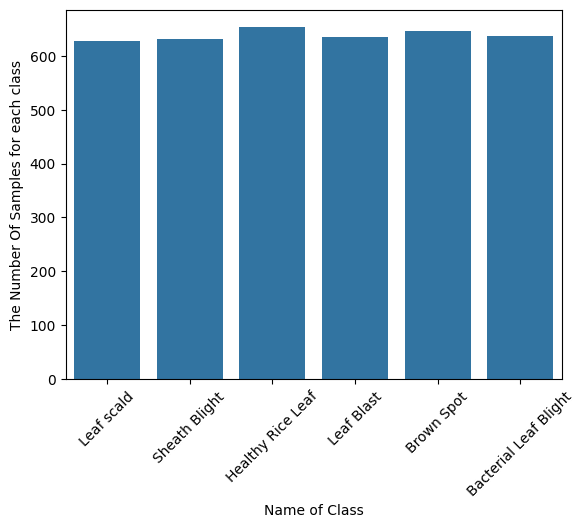

In [9]:
ax = sns.countplot(x=df.label)

ax.set_xlabel("Name of Class")
ax.set_ylabel("The Number Of Samples for each class")

plt.xticks(rotation=45)
plt.show()

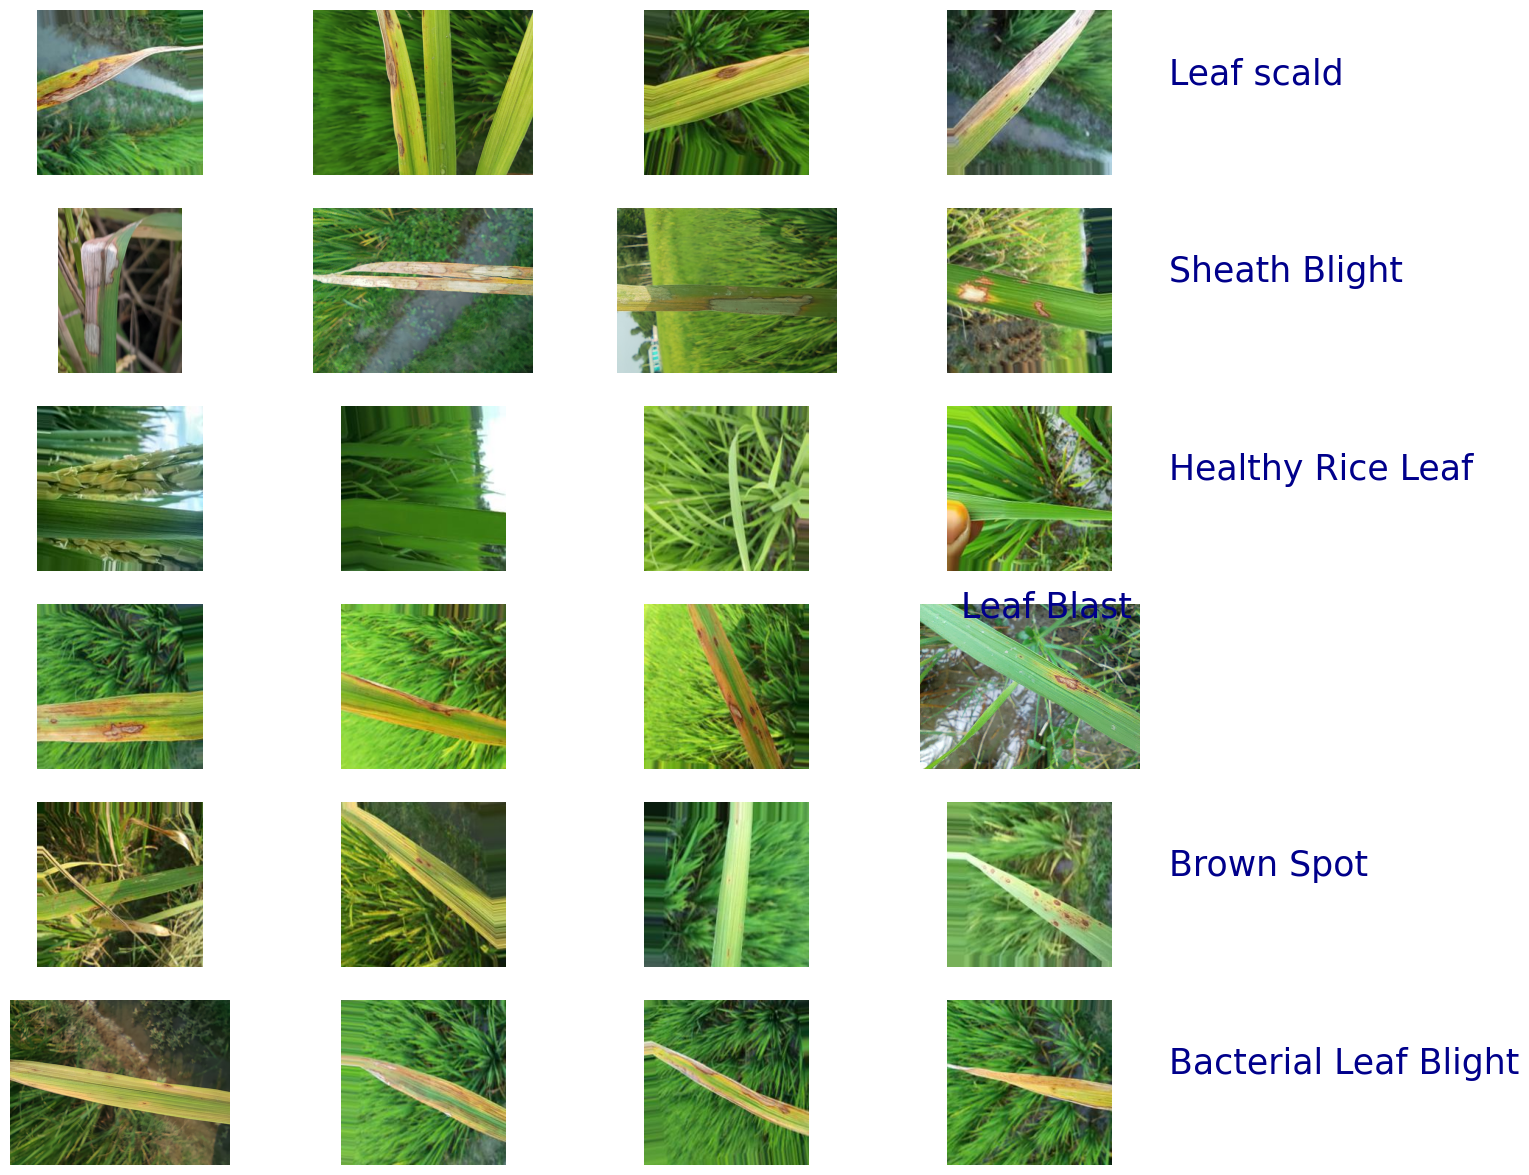

In [10]:


fig = plt.figure(figsize=(15, 15))
gs = GridSpec(6, 4, figure=fig)

for i, category in enumerate(df['label'].unique()):
    filepaths = df[df['label'] == category]['image'].values[:4]
    
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    
    ax.text(300, 100, category, fontsize=25, color='darkblue')

plt.show()

In [11]:

def get_image_info(path):
    try:
        with Image.open(path) as img:
            width, height = img.size
            format = img.format
            mode = img.mode
        return pd.Series([width, height, format, mode])
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return pd.Series([None, None, None, None])

df[['width', 'height', 'format', 'mode']] = df['image'].apply(get_image_info)

In [12]:
df.head()

,image,label,width,height,format,mode
0,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf scald,224,224,JPEG,RGB
1,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf scald,1600,1200,JPEG,RGB
2,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf scald,224,224,JPEG,RGB
3,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf scald,224,224,JPEG,RGB
4,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf scald,224,224,JPEG,RGB


In [13]:
all_equal = (
    df['width'].nunique() == 1 and
    df['height'].nunique() == 1 and
    df['format'].nunique() == 1 and
    df['mode'].nunique() == 1
)

if all_equal:
    print("All images have the same width, height, format, and mode.")
else:
    print("Images differ in size, format, or mode.")
    print("Unique variations:")
    df[['width', 'height', 'format', 'mode']].drop_duplicates()

Images differ in size, format, or mode.
Unique variations:


In [14]:


# First split: train+val vs test 
df_train_val, df_test = train_test_split(
    df,
    test_size=0.1,
    stratify=df['label'],
    random_state=42
)

# Second split: train vs validation
df_train, df_val = train_test_split(
    df_train_val,
    test_size=0.2,
    stratify=df_train_val['label'],
    random_state=42
)

print(len(df_train), len(df_val), len(df_test))

2756 690 383


In [15]:
df_train['image'] = df_train['image'].astype(str)
df_val['image'] = df_val['image'].astype(str)
df_test['image'] = df_test['image'].astype(str)

In [16]:
df_train.head()

,image,label,width,height,format,mode
160,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf scald,224,224,JPEG,RGB
1199,../input/rice-disease-dataset/Rice_Leaf_AUG/Sh...,Sheath Blight,224,224,JPEG,RGB
3657,../input/rice-disease-dataset/Rice_Leaf_AUG/Ba...,Bacterial Leaf Blight,224,224,JPEG,RGB
2045,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf Blast,1600,1200,JPEG,RGB
2221,../input/rice-disease-dataset/Rice_Leaf_AUG/Le...,Leaf Blast,224,224,JPEG,RGB


In [17]:
classes = ['Leaf scald', 'Sheath Blight', 'Healthy Rice Leaf', 'Leaf Blast', 'Brown Spot', 'Bacterial Leaf Blight']

# Data Split

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [19]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image',
    y_col='label',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    classes=classes,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='image',
    y_col='label',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    classes=classes,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='label',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    classes=classes,
    shuffle=False
)

Found 2756 validated image filenames belonging to 6 classes.
Found 690 validated image filenames belonging to 6 classes.
Found 383 validated image filenames belonging to 6 classes.


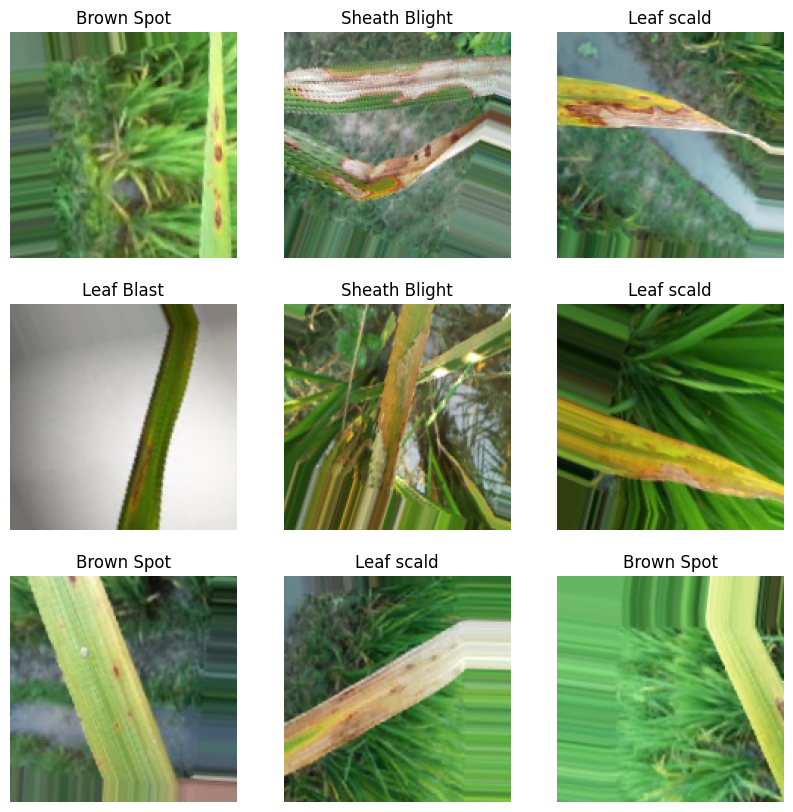

In [20]:
images, labels = next(train_generator)

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i].argmax()])
    plt.axis("off")

plt.show()

# Building the Model

In [21]:
input_shape = (150, 150, 3) 
num_classes = len(classes)

In [22]:
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv2D(65, 3, activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(35, 3, activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(6,activation="softmax"))

I0000 00:00:1767380094.390684      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767380094.394620      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [23]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [24]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_generator,
    epochs=120,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/120


I0000 00:00:1767380100.587118     129 service.cc:152] XLA service 0x7b4b300064c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767380100.587152     129 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767380100.587156     129 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767380101.052195     129 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-02 18:55:03.910896: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-02 18:55:04.066539: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 2/44 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.1055 - loss: 1.9039 

I0000 00:00:1767380108.274075     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/44 ━━━━━━━━━━━━━━━━━━━━ 10s 773ms/step - accuracy: 0.1845 - loss: 1.8089

2026-01-02 18:55:32.368935: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-02 18:55:32.510817: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 992ms/step - accuracy: 0.2094 - loss: 1.7763 - val_accuracy: 0.3855 - val_loss: 1.4730 - learning_rate: 0.0010
Epoch 2/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 812ms/step - accuracy: 0.3650 - loss: 1.5090 - val_accuracy: 0.5188 - val_loss: 1.2302 - learning_rate: 0.0010
Epoch 3/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 809ms/step - accuracy: 0.5304 - loss: 1.2555 - val_accuracy: 0.5464 - val_loss: 1.1150 - learning_rate: 0.0010
Epoch 4/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 809ms/step - accuracy: 0.5723 - loss: 1.1737 - val_accuracy: 0.6000 - val_loss: 1.0611 - learning_rate: 0.0010
Epoch 5/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 816ms/step - accuracy: 0.5858 - loss: 1.1245 - val_accuracy: 0.5971 - val_loss: 1.0177 - learning_rate: 0.0010
Epoch 6/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 798ms/step - accuracy: 0.5942 - loss: 1.0995 - val_accuracy: 0.6159 - val_loss: 0.9819 - learning_rate: 0.0010
Epoch 7/120
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 809ms/step - accuracy: 0.6190 - loss: 1.0136 

In [26]:
_, baseline_model_accuracy=model.evaluate(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 939ms/step - accuracy: 0.9508 - loss: 0.1626


In [27]:
print('Baseline test accuracy:', baseline_model_accuracy)

Baseline test accuracy: 0.9477806687355042


In [28]:
model.save("rice_defect_classifier.keras")

In [29]:
model.export("saved_rice_defect_model_fp32")

INFO:tensorflow:Assets written to: saved_rice_defect_model_fp32/assets


INFO:tensorflow:Assets written to: saved_rice_defect_model_fp32/assets


Saved artifact at 'saved_rice_defect_model_fp32'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135568122073680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568122071376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568122072528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135568122069840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566243038800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566243039568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566243038416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566243039760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566243038608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566243040720: TensorSpec(shape=(), dtype=tf.resource, name=None)


# Converting to INT8 Quantized TFLite model

In [30]:


def representative_dataset():
    for i in range(44):  # 100–300 is enough
        images, _ = train_generator[i]
        yield [images]


converter = tf.lite.TFLiteConverter.from_saved_model("saved_rice_defect_model_fp32")

converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_dataset


converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

with open("rice_defect_classifier_int8.tflite", "wb") as f:
    f.write(tflite_model)

W0000 00:00:1767383498.514867      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767383498.514904      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1767383498.522495      55 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [31]:
interpreter = tf.lite.Interpreter(model_path="rice_defect_classifier_int8.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input dtype:", input_details[0]["dtype"])
print("Output dtype:", output_details[0]["dtype"])


Input dtype: <class 'numpy.uint8'>
Output dtype: <class 'numpy.uint8'>


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [32]:
for op in interpreter._get_ops_details():
    print(op["op_name"])

QUANTIZE
CONV_2D
MAX_POOL_2D
CONV_2D
MAX_POOL_2D
CONV_2D
MAX_POOL_2D
RESHAPE
FULLY_CONNECTED
FULLY_CONNECTED
SOFTMAX
QUANTIZE
DELEGATE


In [33]:
input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]

# Trade-Off Analysis

In [34]:
def tflite_predict_single(image):
    image = np.expand_dims(image, axis=0).astype(np.float32)

    image_uint8 = np.clip(image * 255.0, 0, 255).astype(np.uint8)

    interpreter.set_tensor(input_details[0]["index"], image_uint8)
    interpreter.invoke()

    output_q = interpreter.get_tensor(output_details[0]["index"])
    out_scale, out_zero = output_details[0]["quantization"]

    output = (output_q.astype(np.float32) - out_zero) * out_scale
    return np.argmax(output[0])


In [ ]:
def keras_predict_single(image):
    image = np.expand_dims(image, axis=0) 
    pred = model.predict(image, verbose=0)
    return np.argmax(pred[0])

In [ ]:

correct_fp32 = 0
correct_int8 = 0
total = 0
batch = 0

MAX_IMAGES = 500 

for images, labels in test_generator:
    batch += 1

    for image, label in zip(images, labels):
        true_class = np.argmax(label)

        pred_fp32 = keras_predict_single(image)
        pred_int8 = tflite_predict_single(image)

        correct_fp32 += (pred_fp32 == true_class)
        correct_int8 += (pred_int8 == true_class)
        total += 1

        if total >= MAX_IMAGES:
            break

    print(
        f"Batch {batch} | "
        f"FP32 Acc: {correct_fp32/total:.4f} | "
        f"INT8 Acc: {correct_int8/total:.4f}"
    )

    if total >= MAX_IMAGES:
        break

print("Final Results on", total, "images")
print("FP32 Accuracy :", correct_fp32 / total)
print("INT8 Accuracy :", correct_int8 / total)


Batch 1 | FP32 Acc: 0.9688 | INT8 Acc: 0.9688
Batch 2 | FP32 Acc: 0.9531 | INT8 Acc: 0.9531
Batch 3 | FP32 Acc: 0.9479 | INT8 Acc: 0.9479
Batch 4 | FP32 Acc: 0.9414 | INT8 Acc: 0.9453
Batch 5 | FP32 Acc: 0.9467 | INT8 Acc: 0.9498
Batch 6 | FP32 Acc: 0.9478 | INT8 Acc: 0.9504
Batch 7 | FP32 Acc: 0.9508 | INT8 Acc: 0.9530
Batch 8 | FP32 Acc: 0.9500 | INT8 Acc: 0.9520
Final Results on 500 images
FP32 Accuracy : 0.95
INT8 Accuracy : 0.952


In [37]:

image = next(test_generator)[0][0]   # (H, W, C)
image = np.expand_dims(image, axis=0).astype(np.float32)

for _ in range(10):
    _ = model(image, training=False)

N = 100
start = time.perf_counter()

for _ in range(N):
    _ = model(image, training=False)

end = time.perf_counter()

avg_latency_ms = (end - start) * 1000 / N
print(f"Keras FP32 Inference Time: {avg_latency_ms:.2f} ms")


Keras FP32 Inference Time: 8.73 ms


In [38]:

image_uint8 = np.clip(image * 255.0, 0, 255).astype(np.uint8)

for _ in range(10):
    interpreter.set_tensor(input_details[0]["index"], image_uint8)
    interpreter.invoke()

N = 100
start = time.perf_counter()

for _ in range(N):
    interpreter.set_tensor(input_details[0]["index"], image_uint8)
    interpreter.invoke()

end = time.perf_counter()

avg_latency_ms = (end - start) * 1000 / N
print(f"TFLite INT8 Inference Time: {avg_latency_ms:.2f} ms")

TFLite INT8 Inference Time: 9.09 ms
